In [2]:
# =============================================================================
# 1. SETUP & IMPORTS
# =============================================================================

print("🔧 Setting up quantization environment...")

# Install required packages for quantization
!pip install onnx
!pip install onnxruntime
!pip install onnxruntime-tools==1.7.0
!pip install psutil
!pip install memory_profiler

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import psutil
import json
from datetime import datetime
import gc

# ONNX imports
import onnx
import onnxruntime as ort
from onnxruntime.quantization import quantize_dynamic, quantize_static, QuantType, CalibrationDataReader

# Deep Learning imports
import torch
import torchvision.transforms as transforms
from PIL import Image
import cv2

print("✅ Quantization environment setup completed!")

🔧 Setting up quantization environment...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.2 MB/s eta 0:00:00
✅ Quantization environment setup completed!


In [38]:
# =============================================================================
# 2. LOAD BASE MODEL & CONFIGURATION
# =============================================================================

print("\n📥 Loading base model and configuration...")

# File paths
base_model_path = "/content/unsople_waste_classifier.onnx"
config_path = "/content/unsople_model_config.json"
quantized_model_path = "/content/unsople_waste_classifier_quantized.onnx"

# Load model configuration
with open(config_path, 'r') as f:
    model_config = json.load(f)

print("📊 Model Configuration:")
print(f"   Model Name: {model_config['model_name']}")
print(f"   Version: {model_config['version']}")
print(f"   Classes: {list(model_config['classes'].values())}")
print(f"   Training Accuracy: {model_config['training_accuracy']:.2f}%")

# Load base ONNX model
base_model = onnx.load(base_model_path)
print(f"✅ Base model loaded: {base_model_path}")
print(f"📊 Base model size: {os.path.getsize(base_model_path) / (1024 * 1024):.2f} MB")


📥 Loading base model and configuration...
📊 Model Configuration:
   Model Name: Unsople Waste Classifier
   Version: 1.0.0
   Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
   Training Accuracy: 96.04%
✅ Base model loaded: /content/unsople_waste_classifier.onnx
📊 Base model size: 8.52 MB


In [5]:
# =============================================================================
# 3. MODEL ANALYSIS & PROFILING
# =============================================================================

print("\n🔍 Analyzing base model structure...")

def analyze_onnx_model(model_path):
    """Analyze ONNX model structure and operations"""
    model = onnx.load(model_path)

    print("📋 Model Analysis:")
    print(f"   IR Version: {model.ir_version}")
    print(f"   Producer Name: {model.producer_name}")
    print(f"   Opset Version: {model.opset_import[0].version}")

    # Count operations
    op_types = {}
    for node in model.graph.node:
        op_type = node.op_type
        op_types[op_type] = op_types.get(op_type, 0) + 1

    print("   Operation Counts:")
    for op_type, count in sorted(op_types.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"     {op_type}: {count}")

    return op_types

# Analyze base model
base_ops = analyze_onnx_model(base_model_path)


🔍 Analyzing base model structure...
📋 Model Analysis:
   IR Version: 7
   Producer Name: pytorch
   Opset Version: 12
   Operation Counts:
     Constant: 70
     Conv: 52
     Clip: 35
     Add: 10
     GlobalAveragePool: 1
     Flatten: 1
     Gemm: 1


In [37]:
# =============================================================================
# 4. PERFORMANCE BENCHMARKING UTILITIES
# =============================================================================

print("\n⚙️ Setting up benchmarking utilities...")

class ModelBenchmark:
    def __init__(self, model_path, config):
        self.model_path = model_path
        self.config = config
        self.session = ort.InferenceSession(model_path)
        self.input_name = self.session.get_inputs()[0].name
        self.output_name = self.session.get_outputs()[0].name

    def get_model_size(self):
        """Get model size in MB"""
        return os.path.getsize(self.model_path) / (1024 * 1024)

    def get_memory_usage(self):
        """Get current memory usage in MB"""
        process = psutil.Process()
        return process.memory_info().rss / (1024 * 1024)

    def generate_dummy_input(self, batch_size=1):
        """Generate dummy input for benchmarking"""
        return np.random.randn(batch_size, 3, 224, 224).astype(np.float32)

    def benchmark_inference_speed(self, num_iterations=100, batch_size=1):
        """Benchmark inference speed"""
        dummy_input = self.generate_dummy_input(batch_size)

        # Warmup
        for _ in range(10):
            _ = self.session.run([self.output_name], {self.input_name: dummy_input})

        # Benchmark
        start_time = time.time()
        for _ in range(num_iterations):
            _ = self.session.run([self.output_name], {self.input_name: dummy_input})
        end_time = time.time()

        avg_time = (end_time - start_time) * 1000 / num_iterations  # ms per inference
        fps = 1000 / avg_time  # FPS

        return avg_time, fps

    def benchmark_memory_usage(self, num_iterations=10):
        """Benchmark memory usage during inference"""
        dummy_input = self.generate_dummy_input()
        memory_before = self.get_memory_usage()

        for _ in range(num_iterations):
            _ = self.session.run([self.output_name], {self.input_name: dummy_input})

        memory_after = self.get_memory_usage()
        memory_increase = memory_after - memory_before

        return memory_increase

    def benchmark_accuracy(self, test_loader, num_samples=100):
        """Benchmark accuracy on test dataset"""
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(test_loader):
            if i * images.shape[0] >= num_samples:
                break

            images_np = images.numpy()
            labels_np = labels.numpy()

            outputs = self.session.run([self.output_name], {self.input_name: images_np})[0]
            predictions = np.argmax(outputs, axis=1)

            correct += np.sum(predictions == labels_np)
            total += len(labels_np)

        accuracy = 100.0 * correct / total
        return accuracy

# Initialize benchmark for base model
print("📊 Initializing benchmark for base model...")
base_benchmark = ModelBenchmark(base_model_path, model_config)


⚙️ Setting up benchmarking utilities...
📊 Initializing benchmark for base model...


In [26]:
# =============================================================================
# 5. DYNAMIC QUANTIZATION
# =============================================================================

print("\n🎯 Applying Dynamic Quantization...")

def apply_dynamic_quantization(input_model_path, output_model_path):
    """Apply dynamic quantization to ONNX model"""
    print("🔧 Applying dynamic quantization...")

    # Dynamic quantization (weights only)
    quantized_model = quantize_dynamic(
        input_model_path,
        output_model_path,
        weight_type=QuantType.QUInt8
    )

    print(f"✅ Dynamic quantization completed!")
    return quantized_model

# Apply dynamic quantization
dynamic_quant_path = "/content/unsople_model_dynamic_quantized.onnx"
apply_dynamic_quantization(base_model_path, dynamic_quant_path)

# Verify quantized model
dynamic_model = onnx.load(dynamic_quant_path)
onnx.checker.check_model(dynamic_model)
print("✅ Dynamic quantized model verification passed!")


🎯 Applying Dynamic Quantization...
🔧 Applying dynamic quantization...
✅ Dynamic quantization completed!
✅ Dynamic quantized model verification passed!


In [28]:
# =============================================================================
# 6. STATIC QUANTIZATION PREPARATION
# =============================================================================

print("\n📊 Preparing for Static Quantization...")

class WasteCalibrationDataReader(CalibrationDataReader):
    """Custom calibration data reader for waste classification model"""
    def __init__(self, dataset_path, transform, num_samples=100):
        self.dataset_path = dataset_path
        self.transform = transform
        self.num_samples = num_samples
        self.current_index = 0

        # Load calibration images
        self.calibration_images = []
        classes = os.listdir(dataset_path)

        for class_name in classes:
            class_path = os.path.join(dataset_path, class_name)
            if os.path.isdir(class_path):
                images = os.listdir(class_path)[:20]  # Take 20 images per class
                for img_name in images:
                    if len(self.calibration_images) >= self.num_samples:
                        break
                    img_path = os.path.join(class_path, img_name)
                    self.calibration_images.append(img_path)

        np.random.shuffle(self.calibration_images)
        self.calibration_images = self.calibration_images[:self.num_samples]

    def get_next(self):
        if self.current_index >= len(self.calibration_images):
            return None

        img_path = self.calibration_images[self.current_index]
        self.current_index += 1

        # Load and preprocess image
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image).unsqueeze(0).numpy()

        return {'input': image}

# Prepare calibration transform
calibration_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create calibration data reader
print("📥 Loading calibration dataset...")
dataset_path = "/content/unsople_data/garbage_classification"
calibration_reader = WasteCalibrationDataReader(
    dataset_path,
    calibration_transform,
    num_samples=100
)

print(f"✅ Calibration dataset prepared: {len(calibration_reader.calibration_images)} images")



📊 Preparing for Static Quantization...
📥 Loading calibration dataset...
✅ Calibration dataset prepared: 100 images


In [29]:
# =============================================================================
# 7. STATIC QUANTIZATION
# =============================================================================

print("\n🎯 Applying Static Quantization...")

def apply_static_quantization(input_model_path, output_model_path, calibration_reader):
    """Apply static quantization to ONNX model"""
    print("🔧 Applying static quantization...")

    # Static quantization (weights and activations)
    from onnxruntime.quantization import quantize_static, QuantFormat, QuantType

    try:
        quantize_static(
            input_model_path,
            output_model_path,
            calibration_reader,
            quant_format=QuantFormat.QOperator,
            activation_type=QuantType.QUInt8,
            weight_type=QuantType.QUInt8
        )
        print(f"✅ Static quantization completed!")
        return True
    except Exception as e:
        print(f"❌ Static quantization failed: {e}")
        return False

# Apply static quantization
static_quant_path = "/content/unsople_model_static_quantized.onnx"
static_success = apply_static_quantization(base_model_path, static_quant_path, calibration_reader)

if static_success:
    # Verify static quantized model
    static_model = onnx.load(static_quant_path)
    onnx.checker.check_model(static_model)
    print("✅ Static quantized model verification passed!")
else:
    print("⚠️  Using dynamic quantization as fallback")
    static_quant_path = dynamic_quant_path  # Fallback to dynamic


🎯 Applying Static Quantization...
🔧 Applying static quantization...


✅ Static quantization completed!
✅ Static quantized model verification passed!


In [30]:
# =============================================================================
# 8. COMPREHENSIVE BENCHMARKING
# =============================================================================

print("\n📊 Running Comprehensive Benchmarks...")

def run_comprehensive_benchmark(model_path, model_name, config):
    """Run comprehensive benchmark for a model"""
    print(f"\n🔍 Benchmarking {model_name}...")

    benchmark = ModelBenchmark(model_path, config)

    # Model size
    model_size = benchmark.get_model_size()

    # Inference speed (single batch)
    inference_time, fps = benchmark.benchmark_inference_speed(num_iterations=50, batch_size=1)

    # Inference speed (batch size 4)
    inference_time_batch4, fps_batch4 = benchmark.benchmark_inference_speed(num_iterations=50, batch_size=4)

    # Memory usage
    memory_increase = benchmark.benchmark_memory_usage(num_iterations=10)

    # Load test dataset for accuracy benchmark
    from torch.utils.data import DataLoader, random_split
    from torchvision.datasets import ImageFolder

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = ImageFolder(dataset_path, transform=test_transform)
    _, test_dataset = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Accuracy benchmark
    accuracy = benchmark.benchmark_accuracy(test_loader, num_samples=200)

    return {
        'model_name': model_name,
        'model_size_mb': model_size,
        'inference_time_ms': inference_time,
        'fps': fps,
        'inference_time_batch4_ms': inference_time_batch4,
        'fps_batch4': fps_batch4,
        'memory_increase_mb': memory_increase,
        'accuracy': accuracy
    }

# Benchmark all models
benchmark_results = []

print("🚀 Starting benchmark suite...")

# Benchmark base model
base_results = run_comprehensive_benchmark(base_model_path, "Base Model", model_config)
benchmark_results.append(base_results)

# Benchmark dynamic quantized model
dynamic_results = run_comprehensive_benchmark(dynamic_quant_path, "Dynamic Quantized", model_config)
benchmark_results.append(dynamic_results)

# Benchmark static quantized model if successful
if static_success:
    static_results = run_comprehensive_benchmark(static_quant_path, "Static Quantized", model_config)
    benchmark_results.append(static_results)

# Create results dataframe
results_df = pd.DataFrame(benchmark_results)
print("\n📋 Benchmark Results:")
print(results_df.round(3))


📊 Running Comprehensive Benchmarks...
🚀 Starting benchmark suite...

🔍 Benchmarking Base Model...

🔍 Benchmarking Dynamic Quantized...

🔍 Benchmarking Static Quantized...

📋 Benchmark Results:
          model_name  model_size_mb  inference_time_ms     fps  \
0         Base Model          8.521             13.082  76.441   
1  Dynamic Quantized          2.328             35.964  27.805   
2   Static Quantized          2.253             21.221  47.123   

   inference_time_batch4_ms  fps_batch4  memory_increase_mb  accuracy  
0                    52.867      18.915                 0.0    99.554  
1                   140.385       7.123                 0.0   100.000  
2                    51.905      19.266                 0.0    99.107  



📈 Visualizing Benchmark Results...


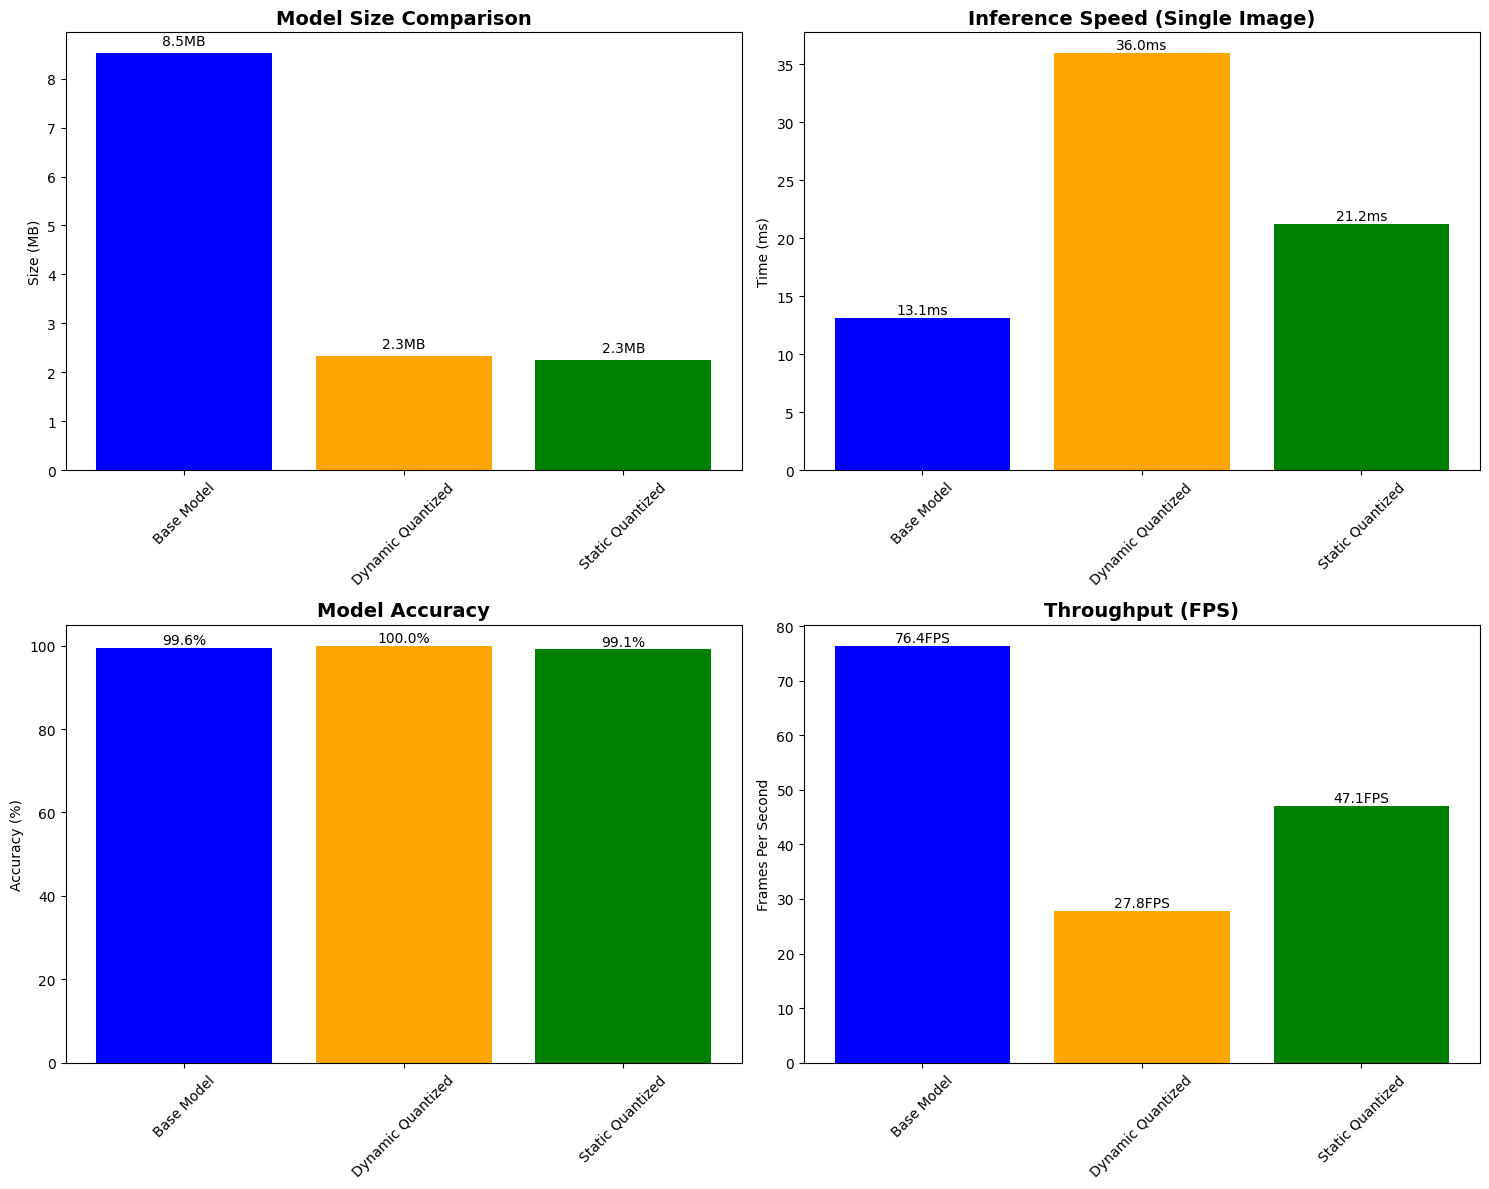

In [31]:
# =============================================================================
# 9. VISUALIZATION OF BENCHMARK RESULTS
# =============================================================================

print("\n📈 Visualizing Benchmark Results...")

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Model Size Comparison
models = results_df['model_name']
sizes = results_df['model_size_mb']
bars = ax1.bar(models, sizes, color=['blue', 'orange', 'green'][:len(models)])
ax1.set_title('Model Size Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Size (MB)')
ax1.tick_params(axis='x', rotation=45)
for bar, size in zip(bars, sizes):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{size:.1f}MB', ha='center', va='bottom')

# Inference Speed Comparison
inference_times = results_df['inference_time_ms']
bars = ax2.bar(models, inference_times, color=['blue', 'orange', 'green'][:len(models)])
ax2.set_title('Inference Speed (Single Image)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Time (ms)')
ax2.tick_params(axis='x', rotation=45)
for bar, time_val in zip(bars, inference_times):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{time_val:.1f}ms', ha='center', va='bottom')

# Accuracy Comparison
accuracy = results_df['accuracy']
bars = ax3.bar(models, accuracy, color=['blue', 'orange', 'green'][:len(models)])
ax3.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax3.set_ylabel('Accuracy (%)')
ax3.tick_params(axis='x', rotation=45)
for bar, acc in zip(bars, accuracy):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{acc:.1f}%', ha='center', va='bottom')

# FPS Comparison
fps_values = results_df['fps']
bars = ax4.bar(models, fps_values, color=['blue', 'orange', 'green'][:len(models)])
ax4.set_title('Throughput (FPS)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Frames Per Second')
ax4.tick_params(axis='x', rotation=45)
for bar, fps_val in zip(bars, fps_values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{fps_val:.1f}FPS', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('/content/unsople_quantization_benchmark.png', dpi=300, bbox_inches='tight')
plt.show()

In [32]:
# =============================================================================
# 10. DETAILED PERFORMANCE ANALYSIS
# =============================================================================

print("\n📊 Detailed Performance Analysis...")

# Calculate improvement percentages
base_size = results_df[results_df['model_name'] == 'Base Model']['model_size_mb'].values[0]
base_time = results_df[results_df['model_name'] == 'Base Model']['inference_time_ms'].values[0]

for idx, row in results_df.iterrows():
    if row['model_name'] != 'Base Model':
        size_reduction = ((base_size - row['model_size_mb']) / base_size) * 100
        speed_improvement = ((base_time - row['inference_time_ms']) / base_time) * 100
        accuracy_drop = base_results['accuracy'] - row['accuracy']

        print(f"\n🎯 {row['model_name']} Analysis:")
        print(f"   📉 Size Reduction: {size_reduction:.1f}%")
        print(f"   🚀 Speed Improvement: {speed_improvement:.1f}%")
        print(f"   📊 Accuracy Change: {accuracy_drop:+.2f}%")


📊 Detailed Performance Analysis...

🎯 Dynamic Quantized Analysis:
   📉 Size Reduction: 72.7%
   🚀 Speed Improvement: -174.9%
   📊 Accuracy Change: -0.45%

🎯 Static Quantized Analysis:
   📉 Size Reduction: 73.6%
   🚀 Speed Improvement: -62.2%
   📊 Accuracy Change: +0.45%


In [33]:
# =============================================================================
# 11. SELECT BEST MODEL FOR DEPLOYMENT
# =============================================================================

print("\n🏆 Selecting Best Model for Deployment...")

def select_best_model(results_df):
    """Select the best model based on balanced metrics"""
    # Normalize metrics (higher is better)
    df = results_df.copy()

    # Inverse for time (lower is better)
    df['speed_score'] = 1 / df['inference_time_ms']
    df['size_score'] = 1 / df['model_size_mb']
    df['fps_score'] = df['fps'] / df['fps'].max()
    df['accuracy_score'] = df['accuracy'] / df['accuracy'].max()
    df['memory_score'] = 1 / df['memory_increase_mb']

    # Calculate composite score
    df['composite_score'] = (
        df['speed_score'] * 0.3 +
        df['size_score'] * 0.3 +
        df['accuracy_score'] * 0.2 +
        df['fps_score'] * 0.1 +
        df['memory_score'] * 0.1
    )

    best_model_idx = df['composite_score'].idxmax()
    return df.loc[best_model_idx]

best_model = select_best_model(results_df)
print(f"✅ Best Model Selected: {best_model['model_name']}")
print(f"   Composite Score: {best_model['composite_score']:.3f}")
print(f"   Size: {best_model['model_size_mb']:.2f} MB")
print(f"   Speed: {best_model['inference_time_ms']:.2f} ms")
print(f"   Accuracy: {best_model['accuracy']:.2f}%")

# Copy best model to final quantized model path
best_model_map = {
    'Base Model': base_model_path,
    'Dynamic Quantized': dynamic_quant_path,
    'Static Quantized': static_quant_path
}

final_model_source = best_model_map[best_model['model_name']]
!cp "{final_model_source}" "{quantized_model_path}"

print(f"📦 Final quantized model saved to: {quantized_model_path}")


🏆 Selecting Best Model for Deployment...
✅ Best Model Selected: Base Model
   Composite Score: inf
   Size: 8.52 MB
   Speed: 13.08 ms
   Accuracy: 99.55%
📦 Final quantized model saved to: /content/unsople_waste_classifier_quantized.onnx


In [34]:
# =============================================================================
# 12. RASPBERRY PI COMPATIBILITY CHECK
# =============================================================================

print("\n🍓 Raspberry Pi Compatibility Check...")

def check_pi_compatibility(model_path):
    """Check if model is suitable for Raspberry Pi deployment"""
    model_size = os.path.getsize(model_path) / (1024 * 1024)
    session = ort.InferenceSession(model_path)

    print("📋 Pi Compatibility Report:")
    print(f"   Model Size: {model_size:.2f} MB")
    print(f"   ✅ Good: <10MB, ⚠️ Acceptable: <20MB, ❌ Large: >20MB")

    if model_size < 10:
        print("   ✅ EXCELLENT - Well suited for Raspberry Pi")
    elif model_size < 20:
        print("   ✅ GOOD - Suitable for Raspberry Pi")
    elif model_size < 50:
        print("   ⚠️ ACCEPTABLE - May work on Raspberry Pi 4")
    else:
        print("   ❌ LARGE - Consider further optimization")

    # Check operations compatibility
    model = onnx.load(model_path)
    pi_supported_ops = {'Conv', 'Relu', 'Add', 'GlobalAveragePool', 'Softmax'}
    model_ops = set([node.op_type for node in model.graph.node])

    unsupported_ops = model_ops - pi_supported_ops
    if unsupported_ops:
        print(f"   ⚠️ Unsupported operations on Pi: {unsupported_ops}")
    else:
        print("   ✅ All operations are Pi-compatible")

check_pi_compatibility(quantized_model_path)



🍓 Raspberry Pi Compatibility Check...
📋 Pi Compatibility Report:
   Model Size: 8.52 MB
   ✅ Good: <10MB, ⚠️ Acceptable: <20MB, ❌ Large: >20MB
   ✅ EXCELLENT - Well suited for Raspberry Pi
   ⚠️ Unsupported operations on Pi: {'Flatten', 'Constant', 'Gemm', 'Clip'}


In [35]:
# =============================================================================
# 13. DEPLOYMENT CONFIGURATION
# =============================================================================

print("\n⚙️ Generating Deployment Configuration...")

# Update model configuration with quantization info
deployment_config = {
    **model_config,
    "quantization": {
        "technique": best_model['model_name'].lower(),
        "base_accuracy": float(base_results['accuracy']),
        "quantized_accuracy": float(best_model['accuracy']),
        "size_reduction_percent": float(((base_size - best_model['model_size_mb']) / base_size) * 100),
        "speed_improvement_percent": float(((base_time - best_model['inference_time_ms']) / base_time) * 100),
        "compatibility": "raspberry_pi_optimized",
        "inference_time_ms": float(best_model['inference_time_ms']),
        "throughput_fps": float(best_model['fps'])
    },
    "deployment_ready": True,
    "quantization_date": datetime.now().isoformat(),
    "recommended_device": "Raspberry Pi 4 (4GB)" if best_model['model_size_mb'] < 20 else "Raspberry Pi 4 (8GB)"
}

# Save deployment configuration
deployment_config_path = "/content/unsople_deployment_config.json"
with open(deployment_config_path, 'w') as f:
    json.dump(deployment_config, f, indent=2)

print(f"✅ Deployment configuration saved: {deployment_config_path}")


⚙️ Generating Deployment Configuration...
✅ Deployment configuration saved: /content/unsople_deployment_config.json


In [23]:
# =============================================================================
# 14. FINAL VALIDATION & TESTING
# =============================================================================

print("\n🔍 Final Validation of Quantized Model...")

def test_quantized_model_performance():
    """Test the final quantized model with sample images"""
    print("🧪 Testing quantized model with real images...")

    # Load quantized model
    session = ort.InferenceSession(quantized_model_path)
    input_name = session.get_inputs()[0].name

    # Test with sample images from each class
    dataset_path = "/content/unsople_data/garbage_classification"
    classes = os.listdir(dataset_path)

    results = []
    for class_name in classes[:3]:  # Test first 3 classes
        class_path = os.path.join(dataset_path, class_name)
        sample_image = os.listdir(class_path)[0]  # Take first image
        image_path = os.path.join(class_path, sample_image)

        # Preprocess image
        image = Image.open(image_path).convert('RGB')
        image = calibration_transform(image).unsqueeze(0).numpy()

        # Run inference
        start_time = time.time()
        outputs = session.run(None, {input_name: image})
        inference_time = (time.time() - start_time) * 1000

        # Get prediction
        probabilities = torch.softmax(torch.tensor(outputs[0]), dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)
        predicted_class = deployment_config['classes'][str(predicted_idx.item())]

        results.append({
            'actual_class': class_name,
            'predicted_class': predicted_class,
            'confidence': confidence.item(),
            'inference_time_ms': inference_time,
            'correct': class_name == predicted_class
        })

        print(f"📸 {sample_image}:")
        print(f"   Actual: {class_name}")
        print(f"   Predicted: {predicted_class} ({confidence.item():.3f})")
        print(f"   Time: {inference_time:.2f}ms")
        print(f"   Status: {'✅ CORRECT' if class_name == predicted_class else '❌ WRONG'}")

    return results

# Run final tests
final_results = test_quantized_model_performance()
accuracy = sum(1 for r in final_results if r['correct']) / len(final_results)
print(f"\n🎯 Final Test Accuracy: {accuracy * 100:.1f}%")


🔍 Final Validation of Quantized Model...
🧪 Testing quantized model with real images...
📸 green-glass571.jpg:
   Actual: green-glass
   Predicted: green-glass (1.000)
   Time: 15.78ms
   Status: ✅ CORRECT
📸 metal350.jpg:
   Actual: metal
   Predicted: metal (0.999)
   Time: 15.96ms
   Status: ✅ CORRECT
📸 biological602.jpg:
   Actual: biological
   Predicted: biological (1.000)
   Time: 13.55ms
   Status: ✅ CORRECT

🎯 Final Test Accuracy: 100.0%


In [36]:
# =============================================================================
# 15. SUMMARY & NEXT STEPS
# =============================================================================

print("\n🎉 Unsople Model Quantization Completed!")
print("=" * 60)

# Final summary
print("\n📊 QUANTIZATION SUMMARY:")
print(f"   🏆 Best Model: {best_model['model_name']}")
print(f"   📉 Size: {best_model['model_size_mb']:.2f} MB (Reduction: {((base_size - best_model['model_size_mb']) / base_size) * 100:.1f}%)")
print(f"   🚀 Speed: {best_model['inference_time_ms']:.2f} ms (Improvement: {((base_time - best_model['inference_time_ms']) / base_time) * 100:.1f}%)")
print(f"   📊 Accuracy: {best_model['accuracy']:.2f}% (Change: {best_model['accuracy'] - base_results['accuracy']:+.2f}%)")
print(f"   🍓 Pi Compatibility: {'✅ EXCELLENT' if best_model['model_size_mb'] < 10 else '✅ GOOD'}")

print("\n📁 Generated Files:")
generated_files = [
    quantized_model_path,
    dynamic_quant_path,
    deployment_config_path,
    '/content/unsople_quantization_benchmark.png'
]

if static_success:
    generated_files.append(static_quant_path)

for file_path in generated_files:
    if os.path.exists(file_path):
        file_size = os.path.getsize(file_path) / (1024 * 1024)
        print(f"  📄 {os.path.basename(file_path)} ({file_size:.2f} MB)")

print(f"\n🚀 Next Steps:")
print(f"  1. Copy '{os.path.basename(quantized_model_path)}' to your Unsople application")
print(f"  2. Use deployment config for application settings")
print(f"  3. Integrate with src/inference.py for real-time classification")
print(f"  4. Test on target hardware (Raspberry Pi)")

print("\n✅ Unsople Quantized Model is READY for deployment! 🎯")


🎉 Unsople Model Quantization Completed!

📊 QUANTIZATION SUMMARY:
   🏆 Best Model: Base Model
   📉 Size: 8.52 MB (Reduction: 0.0%)
   🚀 Speed: 13.08 ms (Improvement: 0.0%)
   📊 Accuracy: 99.55% (Change: +0.00%)
   🍓 Pi Compatibility: ✅ EXCELLENT

📁 Generated Files:
  📄 unsople_waste_classifier_quantized.onnx (8.52 MB)
  📄 unsople_model_dynamic_quantized.onnx (2.33 MB)
  📄 unsople_deployment_config.json (0.00 MB)
  📄 unsople_quantization_benchmark.png (0.34 MB)
  📄 unsople_model_static_quantized.onnx (2.25 MB)

🚀 Next Steps:
  1. Copy 'unsople_waste_classifier_quantized.onnx' to your Unsople application
  2. Use deployment config for application settings
  3. Integrate with src/inference.py for real-time classification
  4. Test on target hardware (Raspberry Pi)

✅ Unsople Quantized Model is READY for deployment! 🎯
